# Gradient Descent and Linear Regression with PyTorch

이 시리즈의 두번째 파트에서는 다음과 같은 항목을 다룹니다.

* 선형 회귀 분석 및 경사 하강법 소개
* PyTorch 텐서를 사용하여 선형 회귀 모델 구현
* 경사 하강 알고리즘을 사용한 선형 회귀 모델 학습
* 내장된 PyTorch를 사용하여 경사 하강법 및 선형 회귀 구현

## Introduction to Linear Regression

이 파트에서는 기계 학습의 기본 알고리즘 중 하나인 선형 회귀(linear regression)에 대해 설명합니다. 지역의 평균 기온, 강우량, 습도(입력 변수 또는 특징)를 보고 사과와 오렌지(목표 변수)의 작물 수확량을 예측하는 모델을 만들 것입니다. 다음은 훈련 데이터입니다.

![linear-regression-training-data](https://i.imgur.com/6Ujttb4.png)

선형 회귀 모델에서 각 목표 변수는 입력 변수의 가중치 합(weighted sum)으로 추정되며 편향(bias)이라고 하는 상수로 오프셋됩니다. :

yield_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1 <br>
yield_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2

시각적으로 사과의 수확량은 온도, 강우량 및 습도의 선형 또는 평면 함수임을 의미합니다.:

![linear-regression-graph](https://i.imgur.com/4DJ9f8X.png)

선형 회귀의 학습 부분은 훈련 데이터를 사용하여 가중치 'w11, w12,... w23, b1 & b2'의 집합을 파악하여 새로운 데이터에 대한 정확한 예측을 수행하는 것입니다. 학습된 가중치는 해당 지역의 평균 온도, 강우량 및 습도를 사용하여 새 지역에서 사과와 오렌지의 수확량을 예측하는 데 사용됩니다.

경사하강법(gradient descent)이라는 최적화 기술을 사용하여 더 나은 예측을 위해 가중치를 약간 여러 번 조정하여 모델을 훈련합니다. Numpy와 PyTorch를 가져오는 것부터 시작하겠습니다.

## Training data

우리는 'inputs'과 'targets'라는 두 개의 행렬을 사용하여 훈련 데이터를 나타낼 수 있으며, 각각 관찰당 하나의 행과 변수당 하나의 열이 있습니다.

In [1]:
import numpy as np
import torch

In [2]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                  [91, 88, 64],
                  [87, 134, 58],
                  [102, 43, 37],
                  [69, 96, 70]], dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70],
                   [81, 101],
                   [119, 133],
                   [22, 37],
                   [103, 119]], dtype='float32')

input 변수와 target 변수를 별도로 작업할 것이기 때문에 분리했습니다. 또한 일반적으로 훈련 데이터로 작업하는 방식이기 때문에 numpy 배열을 만들었습니다. 일반적으로는 CSV 파일을 numpy 배열로 읽고, 일부 처리한 다음 PyTorch 텐서로 변환합니다.

배열을 PyTorch 텐서로 변환해 보겠습니다.

In [3]:
# Convert inputs and targets to tensors

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

print(inputs, targets, sep='\n')

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In [4]:
inputs.shape, targets.shape

(torch.Size([5, 3]), torch.Size([5, 2]))

## Linear regression model from scratch

가중치들과 편향(w11, w12,... w23, b1 & b2)은 임의의 값으로 초기화된 행렬로 나타낼 수 있습니다. 'w'의 첫 번째 행과 'b'의 첫 번째 요소는 첫 번째 target 변수, 즉 사과의 수확량을 예측하는 데 사용되며 유사하게 두 번째는 오렌지의 경우에도 사용됩니다.

In [6]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)

print(w, b, sep='\n')

tensor([[ 0.0366,  0.4488,  0.0023],
        [-0.2065, -0.2698, -0.8840]], requires_grad=True)
tensor([-0.2932, -0.3910], requires_grad=True)


torch.randn은 평균이 0이고 표준편차가 1인 정규 분포에서 무작위로 선택된 요소를 사용하여 주어진 모양의 텐서를 생성합니다.
우리의 모델은 단순히 inputs과 가중치 w(전치)의 행렬 곱셈을 수행하고 편향 b(각 예제에 대해 복제됨)를 더하는 함수입니다.

![matrix-mult](https://i.imgur.com/WGXLFvA.png)

모델은 다음과 같이 정의할 수 있습니다.

In [9]:
def model(x):
    return x @ w.t() + b

@는 PyTorch에서 행렬 곱셈을 나타내고 .t 메서드는 텐서의 전치(transpose)를 반환합니다.
입력 데이터를 모델에 전달하여 얻은 행렬은 대상 변수에 대한 예측 집합입니다.

In [10]:
preds = model(inputs)
print(preds)

tensor([[  32.5490,  -71.5540],
        [  42.6816,  -99.5008],
        [  63.1665, -105.7806],
        [  22.8252,  -65.7641],
        [  45.4807, -102.4198]], grad_fn=<AddBackward0>)


In [11]:
print(targets)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


무작위 가중치와 편향으로 모델을 초기화했기 때문에 모델의 예측과 실제 목표 사이에 큰 차이가 있음을 알 수 있습니다. 무작위로 초기화된 모델이 그냥 작동할 것이라고 기대할 수는 없습니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Loss function

모델을 개선하기 전에 모델이 얼마나 잘 수행되고 있는지 평가할 방법이 필요합니다. 다음 방법을 사용하여 모델의 예측을 실제 목표와 비교할 수 있습니다.

- 두 행렬(preds 및 targets) 간의 차이를 계산합니다.
- 음수 값을 제거하기 위해 차이 행렬의 모든 요소를 제곱합니다.
- 결과 행렬의 요소들의 평균을 계산합니다.

결과는 평균 제곱 오차(MSE)로 알려진 단일 숫자입니다.

In [12]:
# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff**2) / diff.numel()

'torch.sum'은 텐서에 있는 모든 요소의 합을 반환합니다. 텐서의 .numel 메서드는 텐서의 요소 수를 반환합니다. 우리 모델의 현재 예측에 대한 평균 제곱 오차를 계산해 보겠습니다.

In [13]:
# Compute loss
loss = mse(preds, targets)
print(loss)

tensor(18528.6211, grad_fn=<DivBackward0>)


결과를 해석하는 방법은 다음과 같습니다. 평균적으로 예측의 각 요소는 손실의 제곱근만큼 실제 목표와 다릅니다. 그리고 우리가 예측하려는 숫자 자체가 50-200 범위에 있다는 점을 고려할 때 이는 매우 나쁩니다. 결과는 모델이 목표 변수를 예측하는 데 얼마나 나쁜지를 나타내기 때문에 손실(loss)이라고 합니다. 이는 모델의 정보 손실을 나타냅니다. 손실이 낮을수록 모델이 더 좋습니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Compute gradients

PyTorch를 사용하면 'requires_grad'가 'True'로 설정되어 있기 때문에 가중치와 편향에 대한 손실의 기울기(gradients) 또는 미분을 자동으로 계산할 수 있습니다. 이것이 얼마나 유용한지 잠시 후에 살펴보겠습니다.

기울기는 각 텐서의 '.grad' 속성에 저장됩니다. 가중치 행렬에 대한 손실의 미분은 그 자체가 같은 차원의 행렬임에 유의하십시오.

In [14]:
# Compute gradients
loss.backward()

기울기는 각 텐서의 '.grad' 속성에 저장됩니다. 가중치 행렬에 대한 손실의 미분은 그 자체가 같은 차원의 행렬임에 유의하십시오.

In [15]:
# Gradients for weights
print(w)
print(w.grad)

tensor([[ 0.0366,  0.4488,  0.0023],
        [-0.2065, -0.2698, -0.8840]], requires_grad=True)
tensor([[ -2788.2144,  -3582.2583,  -2138.9863],
        [-15022.5654, -16959.9863, -10413.9609]])


----------------------------------------------------------------------------------------------------------------------------------------

## Adjust weights and biases to reduce the loss

손실은 가중치와 편향의 2차 함수이며, 우리의 목표는 손실이 가장 낮은 가중치 집합을 찾는 것입니다. 개별 가중치 또는 편향 요소에 대한 손실 그래프를 플롯하면 아래 그림과 같이 표시됩니다. 미적분학의 중요한 통찰력은 기울기가 가중치와 편향에 대한 손실의 변화율, 즉 손실 함수의 기울기를 나타냅니다.

그래디언트 요소가 양수인 경우:
* 가중치 요소의 값이 약간 증가하면 손실이 증가합니다.
* 가중치 요소의 값이 약간 감소하면 손실이 감소합니다.

![postive-gradient](https://i.imgur.com/WLzJ4xP.png)

그래디언트 요소가 음수인 경우:
* 가중치 요소의 값이 약간 증가하면 손실이 감소합니다.
* 가중치 요소의 값이 약간 감소하면 손실이 증가합니다.

![negative=gradient](https://i.imgur.com/dvG2fxU.png)

가중치 요소를 변경하여 손실의 증가 또는 감소는 그 요소에 대한 손실의 기울기에 비례합니다. 이 관찰은 gradient_를 따라 _descending 모델을 개선하는 데 사용할 gradient descent 최적화 알고리즘의 기초를 형성합니다.

손실을 약간 줄이기 위해서 각 가중치 요소에 대한 손실의 미분에 비례하는 소량을 그 요소에서 뺄 수 있습니다.

In [16]:
w
w.grad

tensor([[ -2788.2144,  -3582.2583,  -2138.9863],
        [-15022.5654, -16959.9863, -10413.9609]])

In [17]:
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5

가중치를 너무 많이 수정하지 않도록 그라디언트에 매우 작은 수(이 경우 '10^-5')를 곱합니다. 우리는 큰 도약이 아닌 경사의 내리막 방향으로 작은 발걸음을 내딛고자 합니다. 이 수치를 알고리즘의 학습률(learning rate)이라고 합니다.

우리는 가중치와 편향을 업데이트하는 동안 그래디언트를 추적, 계산 또는 수정해서는 안 된다고 PyTorch에 나타내기 위해 `torch.no_grad'를 사용합니다.

In [18]:
# Let's verify that the loss is actually lower
loss = mse(preds, targets)
print(loss)

tensor(18528.6211, grad_fn=<DivBackward0>)


계속 진행하기 전에 .zero_() 메서드를 호출하여 그래디언트를 0으로 재설정합니다. PyTorch가 그라디언트를 축적하기 때문에 이 작업을 수행해야 합니다. 그렇지 않으면 다음에 손실에 대해 '.backward'를 호출할 때 새 그라디언트 값이 기존 그라디언트에 추가되어 예기치 않은 결과가 발생할 수 있습니다.

In [19]:
w.grad.zero_()
b.grad.zero_()
print(w.grad, b.grad, sep='\n')

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


----------------------------------------------------------------------------------------------------------------------------------------

## Train the model using gradient descent

위에서 볼 수 있듯이 경사하강 최적화 알고리즘을 사용하여 손실을 줄이고 모델을 개선합니다. 따라서 다음 단계를 사용하여 모델을 _훈련(train)_할 수 있습니다.

1. 예측 생성
2. 손실 계산
3. 가중치와 편향으로 기울기 계산
4. 기울기에 비례하는 소량을 빼서 가중치와 편향을 조정합니다.
5. 그라디언트를 0으로 재설정

In [20]:
# Generate predictions
preds = model(inputs)
print(preds)

tensor([[ 37.9046, -44.7445],
        [ 49.7406, -64.2387],
        [ 71.6335, -63.9427],
        [ 28.0013, -39.2933],
        [ 52.3412, -68.4810]], grad_fn=<AddBackward0>)


In [21]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

tensor(12637.6855, grad_fn=<DivBackward0>)


In [22]:
# Compute gradients
loss.backward()
print(w.grad)
print(b.grad)

tensor([[ -2233.9573,  -2983.1057,  -1770.0067],
        [-12253.0381, -13979.5996,  -8575.6973]])
tensor([ -28.2758, -148.1400])


위에서 계산된 그라디언트를 사용하여 가중치와 편향을 업데이트 해보겠습니다.

In [23]:
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

새로운 가중치와 편향을 살펴보겠습니다.

In [24]:
print(w)
print(b)

tensor([[ 0.0868,  0.5145,  0.0414],
        [ 0.0662,  0.0396, -0.6941]], requires_grad=True)
tensor([-0.2926, -0.3877], requires_grad=True)


새로운 가중치와 편향을 사용하면 모델의 손실이 낮아집니다.

In [25]:
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(8666.2754, grad_fn=<DivBackward0>)


기울기 하강법을 사용하여 가중치와 편향을 약간 조정하는 것만으로 이미 손실을 크게 줄였습니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Train for multiple epochs

손실을 더 줄이기 위해 기울기를 사용하여 가중치와 편향을 조정하는 과정을 여러 번 반복할 수 있습니다. 각 반복을 _epoch_라고 합니다. 100 Epoch 동안 모델을 훈련시켜 봅시다.

In [26]:
# Train for 100 epochs
for i in range(100):
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

다시 한 번 손실이 더 낮아졌는지 확인합니다.

In [27]:
# Calculate loss
loss = mse(model(inputs), targets)
print(loss)

tensor(181.9839, grad_fn=<DivBackward0>)


손실은 이제 초기 값보다 훨씬 낮습니다. 모델의 예측을 보고 목표와 비교해 보겠습니다.

In [28]:
# Predictions
preds

tensor([[ 60.1999,  74.9325],
        [ 80.7183,  95.7132],
        [117.1989, 136.7979],
        [ 38.6480,  63.4456],
        [ 89.0218,  95.0153]], grad_fn=<AddBackward0>)

In [29]:
# Targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

이제 예측이 목표 변수에 매우 가깝습니다. 몇 에포크를 더 훈련하면 더 나은 결과를 얻을 수 있습니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Linear regression using PyTorch built-ins

우리는 몇 가지 기본 텐서 연산을 사용하여 선형 회귀 및 경사 하강 모델을 구현했습니다. 그러나 이것은 딥 러닝의 일반적인 패턴이기 때문에 PyTorch는 몇 줄의 코드로 모델을 쉽게 만들고 훈련할 수 있도록 여러 내장 함수와 클래스를 제공합니다.

신경망 구축을 위한 유틸리티 클래스가 포함된 PyTorch에서 torch.nn 패키지를 가져오는 것부터 시작하겠습니다.

In [7]:
import torch.nn as nn

이전과 마찬가지로 input, targe 및 행렬을 나타냅니다.

In [2]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37], 
                   [69, 96, 70], 
                   [74, 66, 43], 
                   [91, 87, 65], 
                   [88, 134, 59], 
                   [101, 44, 37], 
                   [68, 96, 71], 
                   [73, 66, 44], 
                   [92, 87, 64], 
                   [87, 135, 57], 
                   [103, 43, 36], 
                   [68, 97, 70]], 
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119],
                    [57, 69], 
                    [80, 102], 
                    [118, 132], 
                    [21, 38], 
                    [104, 118], 
                    [57, 69], 
                    [82, 100], 
                    [118, 134], 
                    [20, 38], 
                    [102, 120]], 
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

우리는 15개의 훈련 자료를 사용하여 작은 배치로 대규모 데이터 세트를 작업하는 방법을 보여줍니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Dataset and DataLoader

PyTorch에서 제공하는 다양한 유형의 데이터세트 작업을 위한 표준 API인 'TensorDataset'을 만들어 'inputs' 및 'targets'의 행에 튜플로 액세스할 수 있도록 합니다.

In [3]:
from torch.utils.data import TensorDataset

# Define dataset
train_ds = TensorDataset(inputs, targets)
train_ds[0:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

'TensorDataset'을 사용하면 배열 인덱싱 표기법(위 코드의 '[0:3]')을 사용하여 훈련 데이터의 작은 섹션에 액세스할 수 있습니다. 두 개의 요소가 있는 튜플을 반환합니다. 첫 번째 요소에는 선택한 행에 대한 input 변수가 포함되고 두 번째 요소에는 target이 포함됩니다.

또한 훈련하는 동안 데이터를 미리 정의된 크기의 배치로 분할할 수 있는 'DataLoader'를 만들 것입니다. 또한 데이터 셔플 및 무작위 샘플링과 같은 다른 유틸리티도 제공합니다.

In [4]:
from torch.utils.data import DataLoader

# define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

우리는 for 루프에서 데이터 로더를 사용할 수 있습니다. 예를 들어 보겠습니다.

In [5]:
for xb, yb in train_dl:
    print(xb)
    print(yb)
    break

tensor([[ 88., 134.,  59.],
        [ 74.,  66.,  43.],
        [103.,  43.,  36.],
        [ 91.,  87.,  65.],
        [ 87., 135.,  57.]])
tensor([[118., 132.],
        [ 57.,  69.],
        [ 20.,  38.],
        [ 80., 102.],
        [118., 134.]])


각 반복에서 데이터 로더는 지정된 배치 크기의 데이터 배치 하나를 반환합니다. shuffle이 True로 설정되면 배치를 생성하기 전에 훈련 데이터를 섞습니다. 셔플링은 최적화 알고리즘에 대한 입력을 무작위화하여 손실을 더 빠르게 줄이는 데 도움이 됩니다.

----------------------------------------------------------------------------------------------------------------------------------------

## nn.Linear

가중치와 편향을 수동으로 초기화하는 대신 자동으로 수행하는 PyTorch의 nn.Linear 클래스를 사용하여 모델을 정의할 수 있습니다.

In [8]:
# Define model
model = nn.Linear(3,2)

print(model.weight)
print(model.bias)

Parameter containing:
tensor([[-0.2348,  0.1972,  0.5144],
        [ 0.5730, -0.0447,  0.0883]], requires_grad=True)
Parameter containing:
tensor([0.5373, 0.0472], requires_grad=True)


PyTorch 모델에는 모델에 있는 모든 가중치와 편향 행렬을 포함하는 목록을 반환하는 유용한 .parameters 메서드도 있습니다. 선형 회귀 모델의 경우 하나의 가중치 행렬과 하나의 편향 행렬이 있습니다.

In [9]:
# Parameters
list(model.parameters())

[Parameter containing:
 tensor([[-0.2348,  0.1972,  0.5144],
         [ 0.5730, -0.0447,  0.0883]], requires_grad=True),
 Parameter containing:
 tensor([0.5373, 0.0472], requires_grad=True)]

모델을 사용하여 이전과 같은 방식으로 예측을 생성할 수 있습니다.

In [10]:
preds = model(inputs)
preds

tensor([[18.7293, 42.6786],
        [29.4468, 53.9084],
        [36.3712, 49.0328],
        [ 4.1006, 59.8367],
        [39.2766, 41.4755],
        [18.2973, 43.2962],
        [29.7640, 54.0413],
        [36.6508, 49.6941],
        [ 4.5326, 59.2190],
        [40.0259, 40.9909],
        [19.0465, 42.8116],
        [29.0148, 54.5260],
        [36.0540, 48.8999],
        [ 3.3514, 60.3213],
        [39.7086, 40.8579]], grad_fn=<AddmmBackward>)

----------------------------------------------------------------------------------------------------------------------------------------

## Loss Function

손실 함수를 수동으로 정의하는 대신 내장 손실 함수 mse_loss를 사용할 수 있습니다.

In [11]:
# Import nn.functional
import torch.nn.functional as F

nn.functional 패키지에는 많은 유용한 손실 함수와 기타 여러 유틸리티가 포함되어 있습니다.

In [12]:
# Defin loss function
loss_fn = F.mse_loss

우리 모델의 현재 예측에 대한 손실을 계산해 보겠습니다.

In [13]:
loss = loss_fn(model(inputs), targets)
print(loss)

tensor(3159.9392, grad_fn=<MseLossBackward>)


----------------------------------------------------------------------------------------------------------------------------------------

## Optimizer

그라디언트를 사용하여 모델의 가중치 및 편향을 수동으로 조작하는 대신 옵티마이저 'optim.SGD'를 사용할 수 있습니다. SGD는 "stochastic gradient descent"의 약자입니다. _stochastic_이라는 용어는 샘플이 단일 그룹이 아닌 무작위 배치로 선택됨을 나타냅니다.

In [14]:
# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

model.parameters()는 optim.SGD에 인수로 전달되어 최적화 프로그램이 업데이트 단계 동안 수정해야 하는 행렬을 알 수 있습니다. 또한 매개변수가 수정되는 양을 제어하는 학습률을 지정할 수 있습니다.

----------------------------------------------------------------------------------------------------------------------------------------

## Train the model

이제 모델을 훈련할 준비가 되었습니다. 우리는 경사하강법을 구현하기 위해 동일한 프로세스를 따를 것입니다:

1. 예측 생성
2. 손실 계산
3. 가중치와 편향으로 기울기 계산
4. 기울기에 비례하는 소량을 빼서 가중치를 조정합니다.
5. 그라디언트를 0으로 재설정

유일한 변경 사항은 모든 반복에서 전체 교육 데이터를 처리하는 대신 데이터 배치를 작업한다는 것입니다. 주어진 epoch 수에 대해 모델을 훈련시키는 유틸리티 함수 'fit'을 정의해 보겠습니다.

In [15]:
# Utility function to train the model
def fit(num_epochs, model, loss_fn, opt, train_dl, recode_loss):

  # Repeat for given number of epochs
  for epoch in range(num_epochs):

    # Train with batches of data
    for xb, yb in train_dl:

      # 1. Generate predictions
      pred = model(xb)

      # 2. Calculate loss
      loss = loss_fn(pred, yb)
      recode_loss.append(loss.item())

      # 3. Compute gradients
      loss.backward()

      # 4. Update parameters using gradients
      opt.step()

      # 5. Reset the gradients to zero
      opt.zero_grad()

    # Print the progress
    if (epoch+1) % 10 == 0:
      print('Epoch [{}/{}], loss: {:.4f}'.format(epoch+2, num_epochs, loss.item()))

위에서 주의해야 할 사항:

* 우리는 이전에 정의한 데이터 로더를 사용하여 모든 반복에 대한 데이터 배치를 가져옵니다.

* 매개변수(가중치 및 편향)를 수동으로 업데이트하는 대신 'opt.step'을 사용하여 업데이트를 수행하고 'opt.zero_grad'를 사용하여 그래디언트를 0으로 재설정합니다.

* 훈련 진행 상황을 추적하기 위해 매 10번째 epoch에 대한 마지막 데이터 배치의 손실을 인쇄하는 로그 문도 추가했습니다. 'loss.item'은 손실 텐서에 저장된 실제 값을 반환합니다.

100 Epoch 동안 모델을 훈련시켜봅니다.

In [16]:
# loss값 저장을 위한 list
loss = []

fit(100, model, loss_fn, opt, train_dl, loss)

Epoch [11/100], loss: 369.5336
Epoch [21/100], loss: 351.5048
Epoch [31/100], loss: 105.3316
Epoch [41/100], loss: 119.3316
Epoch [51/100], loss: 84.1856
Epoch [61/100], loss: 87.7183
Epoch [71/100], loss: 55.4246
Epoch [81/100], loss: 53.5232
Epoch [91/100], loss: 25.1330
Epoch [101/100], loss: 28.1458


모델을 사용하여 예측을 생성하고 목표에 가까운지 확인하겠습니다.

In [17]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 57.7260,  72.2928],
        [ 82.7133,  98.7020],
        [115.8121, 134.6786],
        [ 24.4899,  47.8252],
        [100.9784, 109.3830],
        [ 56.5921,  71.4009],
        [ 82.6421,  98.3293],
        [116.1701, 135.0903],
        [ 25.6237,  48.7171],
        [102.0411, 109.9022],
        [ 57.6547,  71.9202],
        [ 81.5795,  97.8101],
        [115.8833, 135.0512],
        [ 23.4272,  47.3059],
        [102.1123, 110.2749]], grad_fn=<AddmmBackward>)

In [18]:
# Compare with targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 57.,  69.],
        [ 80., 102.],
        [118., 132.],
        [ 21.,  38.],
        [104., 118.],
        [ 57.,  69.],
        [ 82., 100.],
        [118., 134.],
        [ 20.,  38.],
        [102., 120.]])

실제로, 예측은 우리의 목표에 매우 가깝습니다. 우리는 한 지역의 평균 기온, 강우량, 습도를 보고 사과와 오렌지의 수확량을 예측할 수 있는 합리적으로 좋은 모델을 훈련했습니다. 단일 입력 행을 포함하는 새로운 지역의 배치를 전달하여 작물 수확량을 예측하는 데 사용할 수 있습니다.

In [47]:
model(torch.tensor([[75., 63, 44]]))

tensor([[55.2596, 68.6450]], grad_fn=<AddmmBackward>)

사과의 예상 수확량은 헥타르당 55.2톤이고 오렌지는 헥타르당 68.6톤입니다.

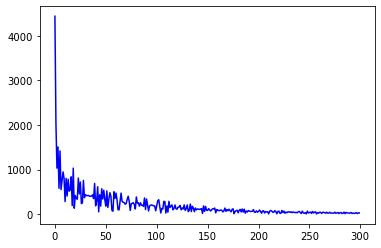

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss, 'b')
plt.show()

----------------------------------------------------------------------------------------------------------------------------------------

## Machine Learning vs. Classical Programming

이 튜토리얼에서 우리가 취한 접근 방식은 여러분이 알고 있는 프로그래밍과 매우 다릅니다. 일반적으로 일부 입력을 받고 일부 작업을 수행하고 결과를 반환하는 프로그램을 작성합니다.

그러나 이 노트북에서는 일부 알려지지 않은 매개변수(가중치 및 편향)를 사용하여 표현되는 입력과 출력 간의 특정 관계를 가정하는 "모델"을 정의했습니다. 그런 다음 모델에 일부 알려진 입력 및 출력을 보여주고 모델을 _훈련_ 하여 알려지지 않은 매개변수에 대한 좋은 값을 도출합니다. 훈련을 마치면 모델을 사용하여 새 입력에 대한 출력을 계산할 수 있습니다.

이러한 프로그래밍 패러다임을 _머신 러닝_ 이라고 하며, 여기서 데이터를 사용하여 입력과 출력 간의 관계를 파악합니다. _딥 러닝_ 은 행렬 연산, 비선형 활성화 함수 및 경사하강법을 사용하여 모델을 구축하고 훈련하는 기계 학습의 한 분야입니다. Tesla Motors의 AI 이사인 Andrej Karpathy는 [Software 2.0](https://medium.com/@karpathy/software-2-0-a64152b37c35)이라는 제목으로 이 주제에 대한 훌륭한 블로그 게시물을 작성했습니다.

Francois Chollet의 책 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)의 이 그림은 고전적 프로그래밍과 기계 학습의 차이점을 포착합니다.

![](https://i.imgur.com/oJEQe7k.png)